In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage, scipy
% matplotlib inline

import glob, os, sys, re, datetime, pickle


In [2]:
gaze_columns = {'GazePointX (ADCSpx)','GazePointY (ADCSpx)'}
quest_col = {'[Age]Value','[Gender]Value','[nationality]Value','[driverslicense]Value','[drugs]Value','[gamer-level]Value','[pong-level]Value'}

usefull_columns = {'PartName','playing_pong', 'watching_pong'} | gaze_columns | quest_col
usefull_columns

{'GazePointX (ADCSpx)',
 'GazePointY (ADCSpx)',
 'PartName',
 '[Age]Value',
 '[Gender]Value',
 '[driverslicense]Value',
 '[drugs]Value',
 '[gamer-level]Value',
 '[nationality]Value',
 '[pong-level]Value',
 'playing_pong',
 'watching_pong'}

In [3]:
posix = lambda x: datetime.datetime.strptime(x,'%d-%m-%Y %H:%M:%S.%f').timestamp()

In [4]:
tobi_exports = glob.glob('Participant_data/*/*.tsv')

In [5]:
def pong_time(tobi_posix, tsv):
  boolean = np.array([False]*len(tobi_posix))
  folder = re.findall(r'.*/',tsv)[0]
  search = os.path.join(folder,'file*.pickle')
  pickles = glob.glob(search)
  for p_file in pickles:
    with open(p_file,'rb') as p:
      p_time = pickle.load(p)[1][[0,-1]]
      
    boolean[(tobi_posix < p_time[1][0]) & (tobi_posix > p_time[0][0])] = True
  return boolean

In [6]:
df = []
for tsv in tobi_exports:
  part = re.findall(r'(Participant_[0-9]+)',tsv)
  temp_df = pd.read_csv(tsv,sep = '\t', dtype = object)
  temp_df['PartName'] = part[0]
  temp_df['time_combi'] = temp_df['RecordingDate'] +' '+ temp_df['LocalTimeStamp']
  temp_df.dropna(subset = ['time_combi'], inplace = True)
  temp_df['posix'] = temp_df['time_combi'].map(posix)
  
  play_pong = pong_time(temp_df['posix'].values, tsv)
  temp_df['playing_pong'] = play_pong
  temp_df['watching_pong'] = temp_df['MediaName'].apply(lambda x: 'just_agent' in x if isinstance(x, str) else False)
  sel_col = list(usefull_columns & set(temp_df.columns))
  df.append(temp_df[sel_col])
df = pd.concat(df)

# Because we changed a question
df.loc[df['[pong-level]Value'] == '2', '[gamer-level]Value']  = '5-6 hours'

In [7]:
df['[pong-level]Value'].unique(), df['[gamer-level]Value'].unique()

(array([nan, '2'], dtype=object),
 array(['7-8 hours', '5-6 hours', '1-2 hours', '0 hours', '3-4 hours'],
       dtype=object))

# Null values

In [8]:
# Total Null values in percentage
df.isnull().sum()/len(df)

GazePointX (ADCSpx)      0.339612
GazePointY (ADCSpx)      0.339612
PartName                 0.000000
[Age]Value               0.000000
[Gender]Value            0.000000
[driverslicense]Value    0.000000
[drugs]Value             0.000000
[gamer-level]Value       0.000000
[nationality]Value       0.000000
[pong-level]Value        0.931113
playing_pong             0.000000
watching_pong            0.000000
dtype: float64

In [9]:
# Null values per participant

df.groupby(['PartName'])['GazePointX (ADCSpx)'].agg([('ratio' ,lambda x: x.isnull().sum()/len(x)), 'count'])

,ratio,count
PartName,,
Participant_1,0.341640,46155
Participant_10,0.348816,47584
Participant_11,0.216741,60795
Participant_12,0.644410,34350
Participant_13,0.180556,64310
Participant_2,0.227447,51700
Participant_3,0.162430,55587
Participant_4,0.639759,28891
Participant_5,0.551363,36004


In [13]:
# How long were they playing/watching
def pif(g):
  play = g['playing_pong'].sum()
  play_null = g[g['playing_pong']]['GazePointX (ADCSpx)'].isnull().sum()
  watch = g['watching_pong'].sum()
  watch_null = g[g['watching_pong']]['GazePointX (ADCSpx)'].isnull().sum()
  other_stuff = ~(g['playing_pong'] | g['watching_pong'])
  other = other_stuff.sum()
  other_null = g[other_stuff]['GazePointX (ADCSpx)'].isnull().sum()
  
  return np.array([0,play-play_null, play_null, watch-watch_null, watch_null, other-other_null, other_null], dtype = np.float)

res = df.groupby(['PartName']).apply(pif)
res = res.iloc[[0,5,6,7,8,9,10,11,12,1,2,3,4]]
plot_values_cumm = np.array([i for i in res.values]).cumsum(axis = 1).T

tot_values = plot_values_cumm[-1]

plot_values_cumm = plot_values_cumm/tot_values

plot_values = np.array([i for i in res.values]).T/ tot_values

['red', 'red', 'purple', 'purple', 'green', 'green']


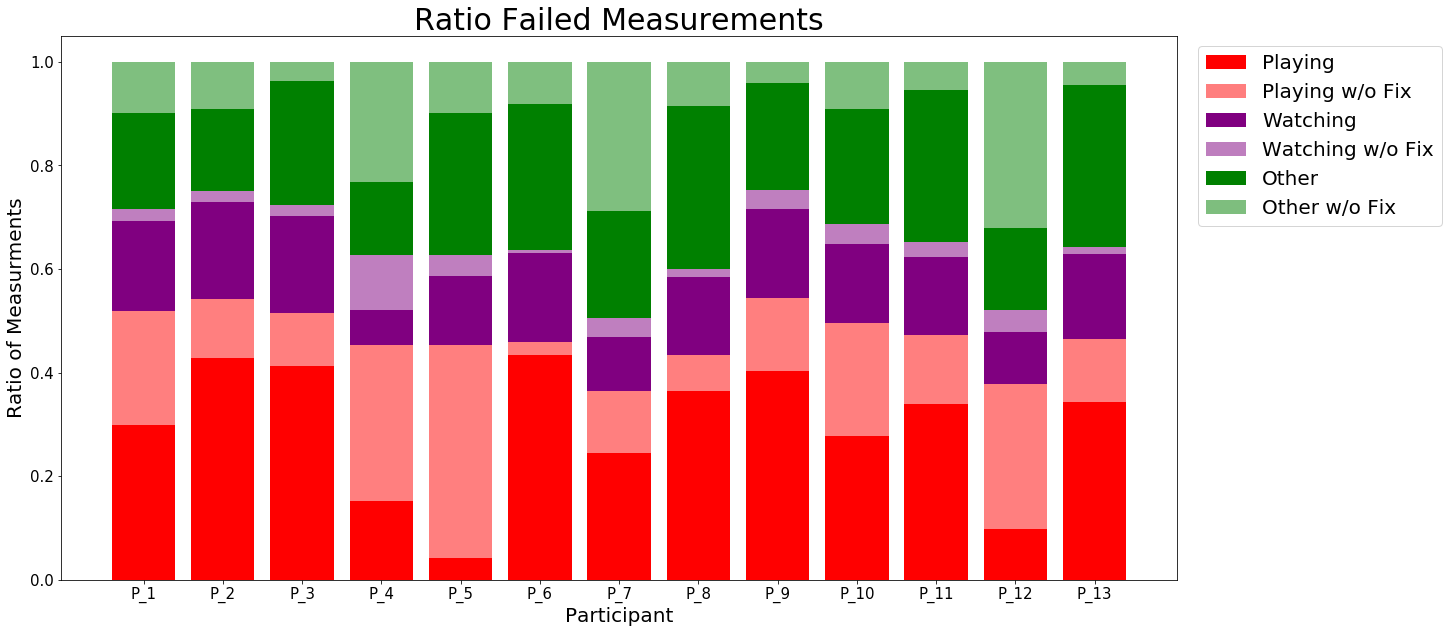

In [19]:
x = np.arange(plot_values.shape[1])

plt.figure(figsize = (20,10))

labels = ['Playing', 'Playing w/o Fix', 'Watching', 'Watching w/o Fix', 'Other','Other w/o Fix']
colors = ['red', 'red', 'purple','purple','green','green']
alphas = [1]*6
alphas = [1,.5,1,.5,1,.5]
print(colors)
for i in range(1,plot_values.shape[0]):
  plt.bar(x,plot_values[i], bottom = plot_values_cumm[i-1], color = colors[i-1], alpha = alphas[i-1], label = labels[i-1])

x_ticks = ['P'+re.findall('(_[0-9]+)', p)[0] for p in res.index]
plt.xticks(x, x_ticks, fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(bbox_to_anchor = (1.01,1), prop = {'size' : 20})

plt.ylabel('Ratio of Measurments', fontsize = 20)
plt.xlabel('Participant', fontsize = 20)
plt.title('Ratio Failed Measurements', fontsize = 30)
plt.savefig('Measurement_ratio.png', bbox_inches = 'tight')
plt.show()

# Participants

In [85]:
quest_col = ['[Age]Value','[Gender]Value','[nationality]Value','[driverslicense]Value','[drugs]Value','[gamer-level]Value']


df_part = df.groupby(['PartName'])[quest_col].min()

In [87]:
df_part['[Age]Value'] = df_part['[Age]Value'].apply(lambda x: 2018-int(x))

In [88]:
df_part

,[Age]Value,[Gender]Value,[nationality]Value,[driverslicense]Value,[drugs]Value,[gamer-level]Value
PartName,,,,,,
Participant_1,24,Female,Born in the USA,Yes,No,5-6 hours
Participant_10,27,Male,German,Yes,No,5-6 hours
Participant_11,27,Female,Greek,Yes,No,0 hours
Participant_12,28,Female,Greek,Yes,No,0 hours
Participant_13,23,Male,Chinese,No,No,3-4 hours
Participant_2,23,Female,Born in the USA,Yes,No,0 hours
Participant_3,25,Male,Italian,Yes,No,0 hours
Participant_4,28,Female,Swedish,No,No,0 hours
Participant_5,23,Female,Italian,No,No,0 hours


In [91]:
h_df = pd.read_csv(tobi_exports[0], sep = '\t')
h_df['time_combi'] = h_df['RecordingDate'] +' '+ h_df['LocalTimeStamp']
h_df.dropna(subset = ['time_combi'], inplace = True)
h_df['posix'] = h_df['time_combi'].map(posix)

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (13,17,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [108]:
len(h_df)/(h_df['posix'].values[-1]-h_df['posix'].values[0])

120.68056339511965

# Test

In [39]:
with open('Participant_data/Participant_1/Play_round_0.pickle','rb') as f:
  data = pickle.load(f)

In [42]:
wanted_images = np.where(data[1]!= 0)[0]

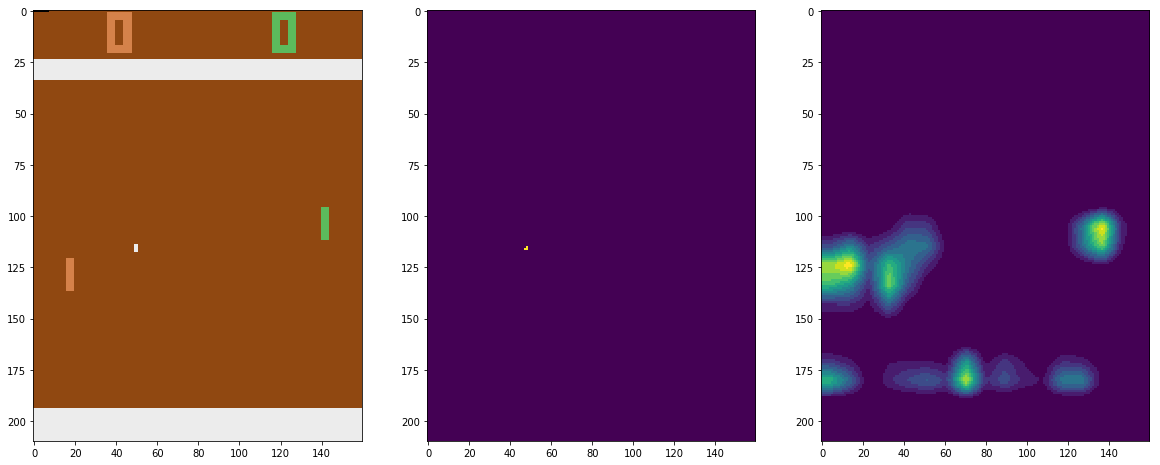

In [53]:
ind = 50
fig, ax = plt.subplots(ncols = 3, figsize = (20,10))
ax[0].imshow(data[0][ind])
ax[1].imshow(data[1][ind])
ax[2].imshow(data[2][ind])


In [65]:
human = skimage.filters.gaussian(data[1][ind])
agent = data[2][ind]

In [69]:
scipy.stats.entropy(human.reshape(-1),agent.reshape(-1))

6.0296461592658925

In [70]:
for i in range(5):
  r_agent = data[2][20+i*5]
  print(scipy.stats.entropy(human.reshape(-1),r_agent.reshape(-1)))

7.616230556173284
7.906973133658604
7.851410375306018
7.812127426163593
7.6508646400129745
